In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [56]:
def fraction(seq):
    n_b = 0.0
    n_bc = 0.0
    n_cb = 0.0
    
    for i in range(0, 32):
        if seq[i] == 1:
            n_b += 1
    
    
    for i in range(1, 32):
        if seq[i-1] + seq[i] == 0:
            if seq[i] == 1:
                n_cb += 1
            else:
                n_bc += 1
    
    n_c = 32.0 - n_b
    p_b = n_b / 32.0
    p_c = n_c / 32.0
    
    p_cb = n_cb / n_b
    p_bb = 1.0 - p_cb
    p_bc = n_bc / n_c
    p_cc = 1.0 - p_bc 
    
    bn = p_bb * p_cc - p_bc * p_cb
    
    return bn

def blockiness(seq):
    """
        seq:    0 0 1 0 1 1
        shift:    0 0 2 0 2 2
        res:      0 1 2 1 3
    """
    seq = (seq + 1)/2
    res = seq[..., 1:] + 2*seq[..., :-1]
    
    nbb = np.count_nonzero(res==0, axis=1)
    nbc = np.count_nonzero(res==1, axis=1)
    ncb = np.count_nonzero(res==2, axis=1)
    ncc = np.count_nonzero(res==3, axis=1)
    nb = np.sum(seq, axis=1)
    nc = 32 - nb
    
    pcb = ncb / nb
    pbb = nbb / nb
    pbc = nbc / nc
    pcc = ncc / nc
    
    BN = pbb*pcc-pbc*pcb
    
    return BN
    

def data_analysis(dataset):
    set = SeqData(dataset=dataset)
    iter = DataLoader(set, batch_size=set.__len__(), shuffle=True)
    # iter = DataLoader(set, 1, shuffle=True)
    for seq, CP, F, BN, label in iter:
        plt.scatter(F, label, marker='.')
        plt.title(dataset+'-F')
        plt.show()
        if dataset == 'D':
            plt.scatter(CP, label, marker='.')
            plt.title(dataset+'-CP')
            plt.show()
        plt.scatter(BN, label, marker='.')
        plt.title(dataset+'-BN')
        plt.show()
    return

def train(dataset, batch_size, lr, epochs):
    set = SeqData(dataset=dataset)
    iter = DataLoader(
        dataset=set,
        batch_size=batch_size,
        shuffle=True,
    )
    Model = SeqModel()
    Loss = nn.MSELoss()
    optimizer = optim.Adam(Model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    curve = list()
    
    # if torch.cuda.is_available():
    #     Model = Model.cuda()
    
    for epoch in range(epochs):
        iter_n, total_loss = 0, 0
        
        for seq, CP, F, BN, label in iter:
            # if torch.cuda.is_available():
            #     cp, seq, label = cp.cuda(), seq.cuda(), label.cuda()
            
            optimizer.zero_grad()
            pred, _ = Model(seq, CP, F, BN)
            loss = Loss(pred, label)
            loss.backward()
            optimizer.step()
            
            total_loss += loss
            iter_n += 1
        
        curve.append(total_loss/iter_n)
        
    # plt.plot(curve)
    # plt.show()

    return Model

def eval(dataset, Model):
    set = SeqData(dataset=dataset)
    iter = DataLoader(
        dataset=set,
        batch_size=set.__len__(),
        shuffle=True,
    )
    Model.eval()

    for seq, CP, F, BN, label in iter:
        pred, SF = Model(seq, CP, F, BN)
    
    pred, SF = pred.detach(), SF.detach()
    plt.scatter(pred, label, marker='.')
    plt.plot([torch.min(label),torch.max(label)],[torch.min(label),torch.max(label)], color='orange', linewidth=2)
    plt.show()
    plt.scatter(SF, label, marker='.')
    plt.show()
    return 

In [61]:
class SeqData(Dataset):
    def __init__(self, root_path='./dataset', dataset='ABCD') -> None:
        super().__init__()
        datasets_path = list(dataset)
        self.datasets = list()
        for subset_path in datasets_path:
            with open(os.path.join(root_path, 'dataset' + subset_path)) as f:
                for data in f.readlines():
                    data = np.array(list(map(float, data.split())))
                    self.datasets.append(data)
        self.datasets = np.array(self.datasets)
        
    def __getitem__(self, index):
        data = self.datasets[index].astype('float32')
        CP, seq, label = data[0].reshape(1), (data[1:-1]*2-1).reshape(1,32), data[-1].reshape(1)
        F = np.mean(seq, axis=1).astype('float32')
        BN = blockiness(seq).astype('float32')
        return seq, CP, F, BN, label

    def __len__(self):
        return np.shape(self.datasets)[0]


<ipython-input-56-f6db76b793aa>:49: RuntimeWarning: invalid value encountered in true_divide
  pbc = nbc / nc
<ipython-input-56-f6db76b793aa>:50: RuntimeWarning: divide by zero encountered in true_divide
  pcc = ncc / nc
<ipython-input-56-f6db76b793aa>:52: RuntimeWarning: invalid value encountered in multiply
  BN = pbb*pcc-pbc*pcb
<ipython-input-56-f6db76b793aa>:47: RuntimeWarning: invalid value encountered in true_divide
  pcb = ncb / nb
<ipython-input-56-f6db76b793aa>:48: RuntimeWarning: divide by zero encountered in true_divide
  pbb = nbb / nb


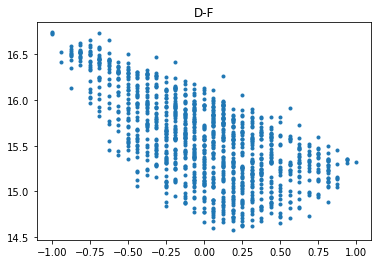

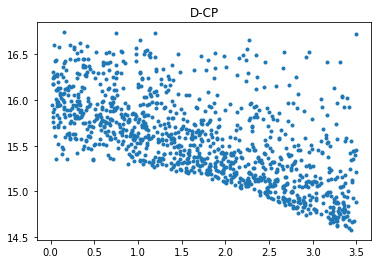

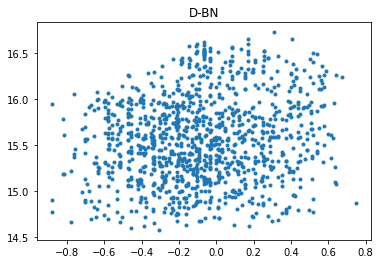

In [62]:
data_analysis('D')

In [65]:
class LeNet1d(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(80, 9)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(9, 1)
        self.relu4 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def SeqForward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        # y = self.relu4(y)
        y = self.sigmoid(y)
        return y
    
class SeqModel(LeNet1d):
    def __init__(self):
        super().__init__()
        self.fc3 = nn.Linear(3, 4)
        self.relu5 = nn.ReLU()
        self.fc4 = nn.Linear(4, 1)
        self.relu6 = nn.ReLU()
    
    def forward(self, seq, CP, F, BN):
        # seq feature
        SF = self.SeqForward(seq)
        # chemical parameter

        x = torch.cat([CP,F,SF], dim=1)

        x = self.fc3(x)
        x = self.relu5(x)
        x = self.fc4(x)
        x = self.relu6(x)
        
        print(x)
        
        return x, SF

In [66]:
Model_A = train(dataset='A',
                batch_size=16,
                lr=1e-2,
                epochs=64)

tensor([[0.4441],
        [0.4442],
        [0.4388],
        [0.4770],
        [0.4390],
        [0.4243],
        [0.4334],
        [0.4178],
        [0.4497],
        [0.4163],
        [0.4121],
        [0.4227],
        [0.4114],
        [0.4771],
        [0.4395],
        [0.4230]], grad_fn=<ReluBackward0>)
tensor([[0.4735],
        [0.4372],
        [0.4522],
        [0.4431],
        [0.4545],
        [0.4895],
        [0.4421],
        [0.4785],
        [0.4363],
        [0.4434],
        [0.4553],
        [0.4622],
        [0.4316],
        [0.4836],
        [0.4502],
        [0.4377]], grad_fn=<ReluBackward0>)
tensor([[0.5061],
        [0.4938],
        [0.4977],
        [0.4992],
        [0.5051],
        [0.5772],
        [0.5001],
        [0.4695],
        [0.4993],
        [0.5119],
        [0.5170],
        [0.4602],
        [0.5121],
        [0.4697],
        [0.4988],
        [0.5054]], grad_fn=<ReluBackward0>)
tensor([[0.4906],
        [0.5762],
        [0.5626],
    

<ipython-input-56-f6db76b793aa>:47: RuntimeWarning: invalid value encountered in true_divide
  pcb = ncb / nb
<ipython-input-56-f6db76b793aa>:48: RuntimeWarning: divide by zero encountered in true_divide
  pbb = nbb / nb
<ipython-input-56-f6db76b793aa>:52: RuntimeWarning: invalid value encountered in multiply
  BN = pbb*pcc-pbc*pcb


tensor([[0.9843],
        [0.9986],
        [1.2846],
        [1.0987],
        [1.1559],
        [1.0987],
        [1.0272],
        [1.1273],
        [1.1559],
        [0.9707],
        [1.2988],
        [1.1273],
        [1.0844],
        [1.0701],
        [1.1559],
        [1.0415]], grad_fn=<ReluBackward0>)
tensor([[1.2671],
        [1.1342],
        [1.1194],
        [1.1785],
        [1.2376],
        [1.1342],
        [1.2080],
        [1.1932],
        [1.1046],
        [1.1637],
        [1.3853],
        [1.0898],
        [1.2966],
        [1.1489],
        [1.1342],
        [1.1046]], grad_fn=<ReluBackward0>)
tensor([[1.3849],
        [1.2469],
        [1.1549],
        [1.0629],
        [1.2929],
        [1.2775],
        [1.0629],
        [1.1702],
        [1.3542],
        [1.2009],
        [1.2775],
        [1.2469],
        [1.2315],
        [1.2469],
        [1.0936],
        [1.3542]], grad_fn=<ReluBackward0>)
tensor([[1.2865],
        [1.2546],
        [1.3184],
    

<ipython-input-56-f6db76b793aa>:49: RuntimeWarning: invalid value encountered in true_divide
  pbc = nbc / nc
<ipython-input-56-f6db76b793aa>:50: RuntimeWarning: divide by zero encountered in true_divide
  pcc = ncc / nc


tensor([[3.7023],
        [3.7579],
        [3.7765],
        [3.7765],
        [3.7394],
        [3.5169],
        [4.0546],
        [3.9248],
        [3.7579],
        [3.8506],
        [3.7765],
        [3.8692],
        [3.7023],
        [3.4983],
        [3.7950],
        [3.7579]], grad_fn=<ReluBackward0>)
tensor([[3.8230],
        [3.6780],
        [3.9318],
        [3.7324],
        [3.8774],
        [3.8049],
        [3.8049],
        [3.8955],
        [3.8593],
        [3.8593],
        [3.6237],
        [3.9318],
        [3.7324],
        [3.6780],
        [3.9861],
        [3.8955]], grad_fn=<ReluBackward0>)
tensor([[4.0340],
        [3.7904],
        [3.8078],
        [4.0514],
        [3.9818],
        [4.1384],
        [3.9122],
        [4.0862],
        [3.9644],
        [3.9992],
        [3.9644],
        [4.0166],
        [3.9818],
        [3.8774],
        [4.0340],
        [4.1210]], grad_fn=<ReluBackward0>)
tensor([[4.1066],
        [4.1232],
        [4.0900],
    

In [ ]:
Model_B = train(dataset='B',
                batch_size=16,
                lr=1e-2,
                epochs=64)

In [ ]:
Model_C = train(dataset='C',
                batch_size=16,
                lr=1e-2,
                epochs=64)

In [ ]:
Model_D = train(dataset='D',
                batch_size=16,
                lr=1e-2,
                epochs=64)

In [ ]:
Model_all = {
    'A': Model_A.state_dict(),
    'B': Model_B.state_dict(),
    'C': Model_C.state_dict(),
    'D': Model_D.state_dict(),
}
if not os.path.exists('./checkpoints'):
    os.mkdir('./checkpoints')
torch.save(Model_all, './checkpoints/Model_all.pth')

In [67]:
eval('A', Model_A)

NameError: name 'Model_D' is not defined